# 14주차 군집화(2) 복습과제
- 총 3개의 문제로 구성되어 있으며, 3번은 관심있으신 분만 풀어보시면 됩니다.
- 1, 2번은 코드를 쳐서 제출해주시면 되며, 3번은 직접 풀어서 pdf로 제출하시거나 markdown 양식으로 제출하시면 됩니다.
- 1, 2번 문제는 Gaussian mixture fitting 과정에서 시간이 오래걸릴 수 있으니, 가급적이면 여유를 가지고 풀어주세요.
- 1, 2번 문제들의 output은 제대로 풀었을 때의 기대 output입니다. 비교하면서 푸시는걸 권장합니다.
- 답안의 획일성을 위해 random_state가 argument로 들어가는 모든 함수는 random_state = 0 으로 맞춰주세요.

### 문제 1 : data generation
- 세션 중 언급한 generative model의 특징을 Gaussian mixture model을 이용하여 확인해보는 문제입니다.
- 'Brain Tumor.zip' 파일은 뇌종양 판단을 위해 MRI 단층촬영한 사진들이며, 총 3762장입니다.
- 위 사진들을 이용해 Gaussian mixture model을 만든 후, 역으로 가짜 MRI 단층사진을 생성해볼 것입니다.
- 먼저 다음 cell을 실행시켜주세요.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy as np
from PIL import Image
import os, os.path

#### 문제 1-1 
이미지 파일을 np.array 형태로 불러오고자 합니다. 
- 주석을 참고하여 '???'를 적당한 코드로 채워주세요.

In [2]:
imgs = []
base_path = "./Brain Tumor/"
valid_images = [".jpg", ".jpeg", ".png"]

path = base_path
for f in os.listdir(path):
    
    # ext로 파일 확장자명을 저장한 후, valid_images에 있는 유효한 확장자인지 확인.
    ext = os.path.splitext(f)[-1]
    if ext.lower() not in valid_images:
        continue
        
    # 이미지를 불러오고 grayscale로 변환.
    img = Image.open(os.path.join(path, f)).convert('L')
    
    # 불러온 이미지를 120 * 120 pixel로 변환.
    img_resize = img.resize((120, 120))
    imgs.append(img_resize)

# 각 이미지들을 1d array로 바꾼 후, imgs의 형태가 2d array가 되도록 저장.
imgs = np.array([np.asarray(img).reshape(-1) for img in imgs])
imgs.shape

(3762, 14400)

#### 문제 1-1  (continued)
위에서 얻은 np.array 형태의 이미지 데이터들 중 100개를 10 * 10 형태의 배열의 이미지로 출력하는 함수를 만들고자 합니다. 

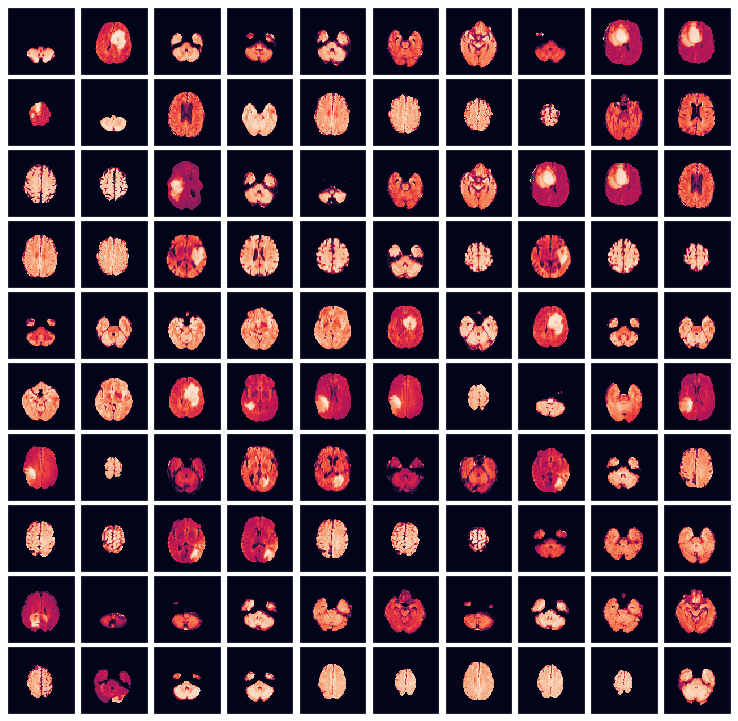

In [3]:
def plot_brains(data):
    fig, axes = plt.subplots(10, 10, figsize = (13, 13),
                           subplot_kw = dict(xticks = [], yticks = []))
    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    for i, ax in enumerate(axes.flat):
        
        # 1d np.array 형태의 이미지 데이터를 다시 120 * 120 pixel의 이미지로 변환.
        im = ax.imshow(Image.fromarray(data[i].reshape(120, 120)))
        
plot_brains(imgs)

#### 문제 1-2 
120 \* 120 pixel의 이미지 데이터는 14400개의 pixel 값으로 구성됩니다. 즉, 데이터의 변수가 14400개나 됩니다.

현재 가지고 있는 데이터 수는 3762개이기 때문에, 차원축소가 불가피한 상황으로 보입니다. 

- PCA를 이용하여 먼저 차원을 축소시켜 주세요. 단, 전체 분산의 95%는 보존되도록 PCA를 실행해주시고, whiten = True로 지정해주세요.

- 차원축소된 데이터의 shape을 출력해보세요.

참고로 whiten은 correlation matrix를 이용하여 PCA를 진행하게 해주는 변수입니다.

이미지 데이터를 다룰 때는 보통 whiten = True 로 지정합니다. 어떤 이유로 그럴까요? 주석으로 적어주세요.

In [4]:
# 'whiten=True' 옵션은 correlation matrix를 이용하여 input의 feature들을 uncorrelated하게 만들어준다.
# (각 feature들 간 서로 작은 correlation을 지니고 동일한 variance를 가지도록 하는 일종의 scaling 작업)
# 이미지 데이터는 픽셀 위치가 조금만 변해도 다른 이미지로 인식하기 때문에 원본 픽셀 공간에서의 계산은 효율적이지 않다.
# (인접한 픽셀들이 높은 correlation을 가졌기 때문에)
# 따라서 whitening을 이용해 스케일을 조정하고 계산하는 것이 더 효율적이다.

#pca = PCA(0.95, whiten=True, random_state=0)
pca = PCA(n_components=220, whiten=True, random_state=0)
pca.fit(imgs)
pca_df = pca.transform(imgs)
pca_df.shape

(3762, 220)

#### 문제 1-3 
이제 Gaussian mixture model을 차원축소된 이미지 데이터로 fitting 하는 작업을 하고자 합니다.

- component의 개수를 50부터 200까지 5만큼의 간격으로 바꿔가면서 Gaussian mixture model을 만들고, 차원축소된 데이터로 fitting 해주세요.

- 생성된 각 모델의 aic와 bic를 비교하는 그림을 그려주세요. (단, random_state = 0 을 지정해주세요.)

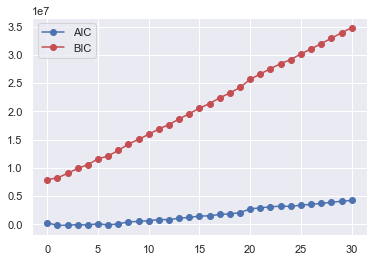

In [5]:
AIC = []; BIC = []
min_components = 50; max_components = 200
for comp in range(min_components, max_components+1, 5):
    gmm = GaussianMixture(n_components=comp, random_state=0).fit(pca_df)
    AIC.append(gmm.aic(pca_df))
    BIC.append(gmm.bic(pca_df))    
    
plt.plot(AIC, marker='o', label='AIC', color='b')
plt.plot(BIC, marker='o', label='BIC', color='r')
plt.legend()

#### 문제 1-4 
변수 개수가 너무 많아서인지 BIC는 모델 선택 기준으로 좋아보이지 않습니다.

BIC 대신 AIC를 이용하여 생성된 모델 중 최적 모델을 선택하고자 합니다.

최적 모델을 선택한 후, 해당 모델의 EM 알고리즘이 수렴했는지 확인해보세요. (힌트: GaussianMixture의 attribute들을 확인해보세요.)

In [6]:
n = 50 + AIC.index(min(AIC))*5
gmm_final = GaussianMixture(n_components=n, random_state=0).fit(pca_df)
gmm_final.converged_

True

#### 문제 1-5 
선택된 모델에서 100개의 random sample을 추출한 후, 이 sample들을 이미지로 바꿔보는 작업을 하려고 합니다.
- 먼저 문제 1-4에서 선택한 모델에서 100개의 sample을 추출해주세요.
- 그 후, PCA의 역변환을 이용하여 차원축소 전의 데이터 형태로 복원해주세요. (힌트: PCA의 method들을 살펴보세요.)
- 마지막으로 1-1번에서 만들었던 plt_brains 함수로 10 \* 10 배열의 이미지를 그려주세요.

생성된 가짜 이미지를 1-1번의 진짜 이미지와 비교해보세요. 그럴듯하지 않나요? :)

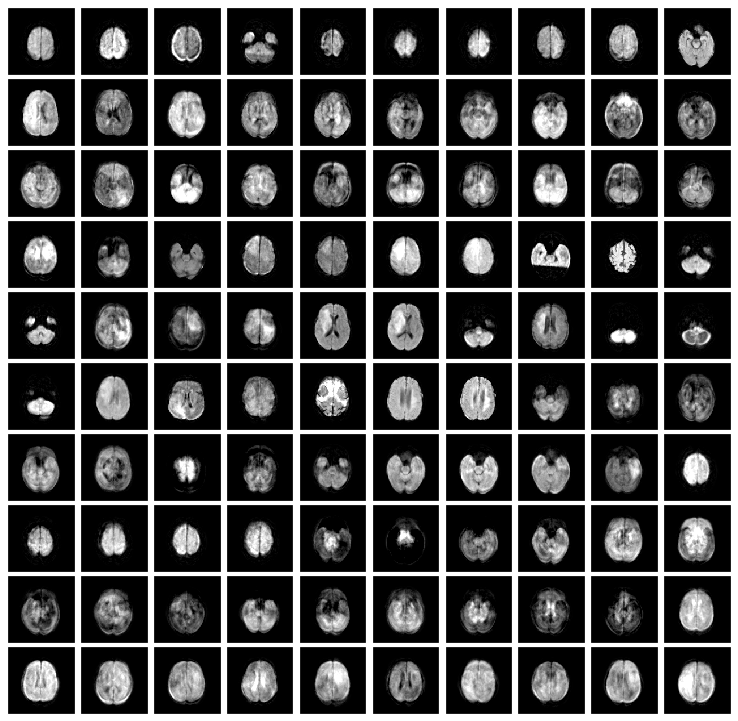

In [7]:
# 100개의 sample 추출
samples = gmm_final.sample(100)

# 차원축소 전의 데이터로 복원
fake_img = pca.inverse_transform(samples[0])

# 가짜 이미지 생성
def plot_brains(data):
    fig, axes = plt.subplots(10, 10, figsize = (13, 13),
                           subplot_kw = dict(xticks = [], yticks = []))
    fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
    for i, ax in enumerate(axes.flat):
        
        im = ax.imshow(Image.fromarray(data[i].reshape(120, 120)))
        
plot_brains(fake_img)

### 문제 2 : image segmentation
- Gaussian mixture 클러스터링을 이용하여 image color segmentation을 하는 문제입니다. 
- 'korea.jpg'는 한옥사진이며, 1920 \* 1200 pixel로 구성되어 있습니다.
- 이번엔 RGB 값으로 Gaussian mixture fitting을 한 후, 각 component의 평균으로 해당 클러스터의 색을 segmentation 할 것입니다.

#### 문제 2-1 
- 'korea.jpg'를 1920 \* 1200 pixel이 아닌 576 \* 360 pixel의 형태로 불러와주세요.
- 이번엔 grayscale로 변환하지 말아주세요.
- 불러온 후 plt.imshow( )를 이용하여 다음 cell의 output처럼 출력해주세요. 

(힌트: plt.axis('off')를 이용해보세요.)

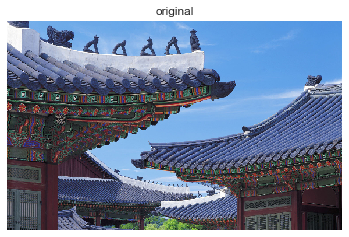

In [8]:
img = Image.open('korea.jpg').resize((576, 360))
plt.axis('off')
plt.title('original')
plt.imshow(img)

#### 문제 2-2 
- 불러온 이미지를 np.array 형태로 바꾼 후, 255로 나눠주세요. (plt.imshow( )는 RGB값이 0과 1사이의 값에서 잘 작동하기 때문에 이런 변환을 합니다.)
- np.array 형태로 변환된 이미지 데이터의 shape을 확인해보세요.

In [9]:
img = np.array(img)/255.
img.shape

(360, 576, 3)

#### 문제 2-3 
이번엔 문제 1과 달리 각 RGB값을 데이터로 생각하고 Gaussian mixture fitting을 할 예정입니다.
- np.array 형태의 데이터를 (576 * 360, 3)의 shape으로 변환해주세요.
- component의 개수를 4, 16, 64로 바꿔가며 Gaussian mixture model을 fitting 해주세요. (단, random_state = 0으로 해주세요.)

참고로 component의 개수는 곧 색의 개수를 의미합니다.

In [10]:
img = img.reshape(576*360, 3)

gmm4 = GaussianMixture(n_components=4, random_state=0)
labels_4 = gmm4.fit(img).predict(img)
gmm16 = GaussianMixture(n_components=16, random_state=0)
labels_16 = gmm16.fit(img).predict(img)
gmm64 = GaussianMixture(n_components=64, random_state=0)
labels_64 = gmm64.fit(img).predict(img)

#### 문제 2-4 
이제 각 component들의 평균을 대표 색깔로 지정하여 이미지 데이터를 다시 생성해주는 함수를 만들고자 합니다.

함수 image_array( )는 각 component들의 평균들과 label들, 즉 소속 클러스터에 대한 정보를 array 형태의 인자로 받습니다.

- 주석을 참고하여 '???'를 적당한 코드로 채워주세요.

In [11]:
# print(gmm4.means_) # (4, 3)
# print(labels_4) # (207360, )

In [24]:
def image_array(component_means, labels):
    
    """
    input ::
    component_means : GMM 모델을 구성하는 각 component들의 평균벡터들.shape : (n_components, 3)
    labels          : GMM 모델을 통해 predict한 데이터들의 소속 component 정보들.shape : (360 * 576, )
    
    return ::
    np.array 형태의 이미지 데이터. shape : (360, 576, 3)
    """
    
    # 원본 데이터와 같은 np.array shape인 360 * 576 * 3 으로 초기화.
    image = np.array(Image.open('korea.jpg').resize((576, 360)))/255.
    
    label_idx = 0
    for i in range(360):
        for j in range(576):
            
            # i, j번째 pixel의 RGB 값을 i, j번째 데이터가 속할 것으로 예측된 component의 평균으로 대체.
            
            idx = labels[label_idx]
            image[i][j] = component_means[idx]
            
            label_idx += 1
    return image

#### 문제 2-5 
이제 fitting된 모델들로 image segmentation 결과를 확인해볼 차례입니다.
- 각 모델별로 image_array( )를 이용하여 np.array 형태의 사진 데이터로 변환한 후, 문제 2-1처럼 이미지를 출력해보세요.

원본 사진과 비교해봤을 때, component의 개수가 증가할수록 어떤 현상이 있나요? image color segmentation이 잘 된 것으로 보이나요?

__component의 개수가 증가할수록 image color segmentation이 잘 이루어집니다~!__

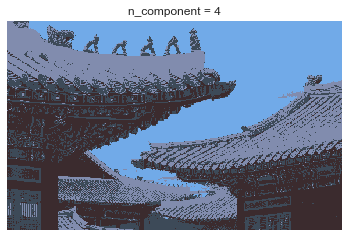

In [25]:
img4 = image_array(gmm4.means_, labels_4)

plt.axis('off')
plt.title('n_component = 4')
plt.imshow(img4)

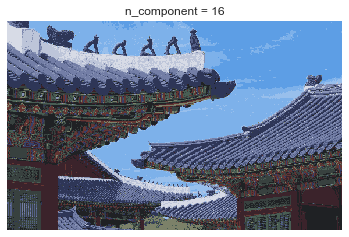

In [26]:
img16 = image_array(gmm16.means_, labels_16)

plt.axis('off')
plt.title('n_component = 16')
plt.imshow(img16)

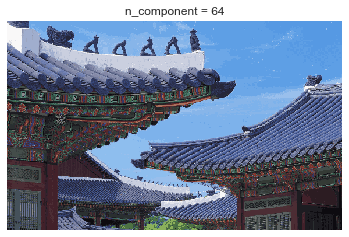

In [27]:
img64 = image_array(gmm64.means_, labels_64)

plt.axis('off')
plt.title('n_component = 64')
plt.imshow(img64)

### 문제 3 : Monotonicity of the EM algorithm
14주차 군집화(2)의 세션 발표자료에 있는 EM 알고리즘의 단조성 정리를 증명해보고자 합니다. 즉, 다음을 보이고자 합니다:

임의의 자연수 $p$에 대해
$$
l(\theta^{(p+1)}|Y_o)\ge l(\theta^{(p)}|Y_o)
$$
이며, 등호성립조건은 다음과 같다:
$$
Q(\theta^{(p+1)}|\theta^{(p)})= Q(\theta^{(p)}|\theta^{(p)})\land k(Y_m|Y_o,\theta^{(p+1)}) = k(Y_m|Y_o,\theta^{(p)})
$$
이를 보이기 위해 먼저 2개의 사실을 문제 3-1, 3-2에서 보일 예정입니다. (해당 문제의 모든 기호와 함수들은 발표자료를 기반으로 합니다.)

$~$
#### 문제 3-1
$H(\theta|\theta^{(p)}) = \mathbb{E}_{Y_m|Y_o,\theta^{(p)}}[\log k(Y_m|Y_o,\theta)]$ 라 할 때, 다음을 보이세요:
$$
Q(\theta|\theta^{(p)}) = l(\theta|Y_o) + H(\theta|\theta^{(p)})
$$

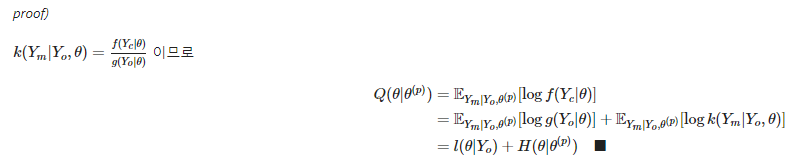

$~$
#### 문제 3-2
다음을 보이세요:
$$
H(\theta^{(p)}|\theta^{(p)}) \ge H(\theta^{(p+1)}|\theta^{(p)})
$$
이며, 등호성립조건은
$$
k(Y_m|Y_o,\theta^{(p+1)}) = k(Y_m|Y_o,\theta^{(p)})
$$

(참고: 위의 등호성립조건은 엄밀하게는 [almost everywhere](https://en.wikipedia.org/wiki/Almost_everywhere) 성립합니다. 여기서는 논의의 편의를 위해 모든 확률밀도함수가 매끄럽게 생겼다고 가정합니다.)

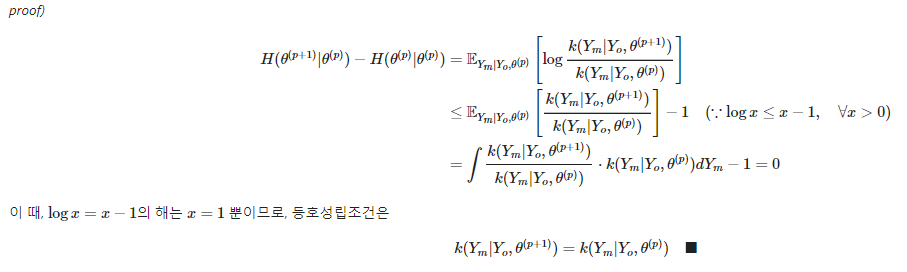

$~$
#### 문제 3-3
문제 3-1과 3-2를 이용하여 EM 알고리즘의 단조성 정리를 증명하세요.

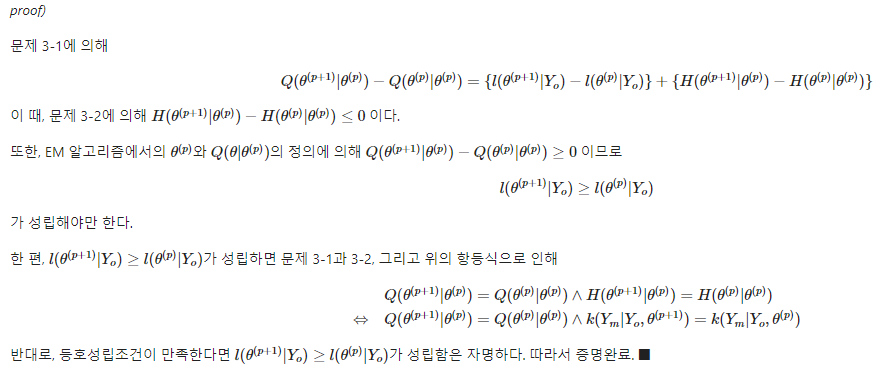

# 고생하셨습니다 :) 